In [43]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.concat([pd.read_csv("results_all.csv"), pd.read_csv("results_all_2.csv")]).iloc[:,1:].drop_duplicates()
df = df[df.label.isin(['APPROVED', 'REJECTED'])]

In [3]:
y = df['label'].apply(lambda x: 1 if x == 'APPROVED' else 0)

In [6]:
X = df.iloc[:, 1:10]

## Train/Test Split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [53]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [54]:
y_pred = clf.predict(X_test)

In [55]:
y_pred_proba = clf.predict_proba(X_test)

In [56]:
accuracy_score(y_test, y_pred)

0.8558558558558559

In [57]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(0, 7, 9, 95)

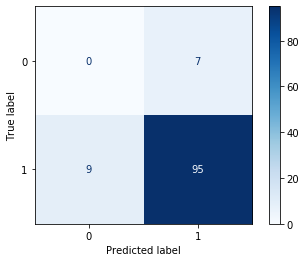

In [58]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)

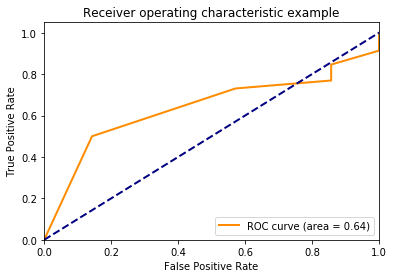

In [60]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred_proba[:, 1]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [61]:
roc_auc_score(y_test, y_pred_proba[:, 1])

0.6394230769230769

In [62]:
abs((2 * roc_auc_score(y_test, y_pred_proba[:, 0])) - 1)

0.27884615384615374

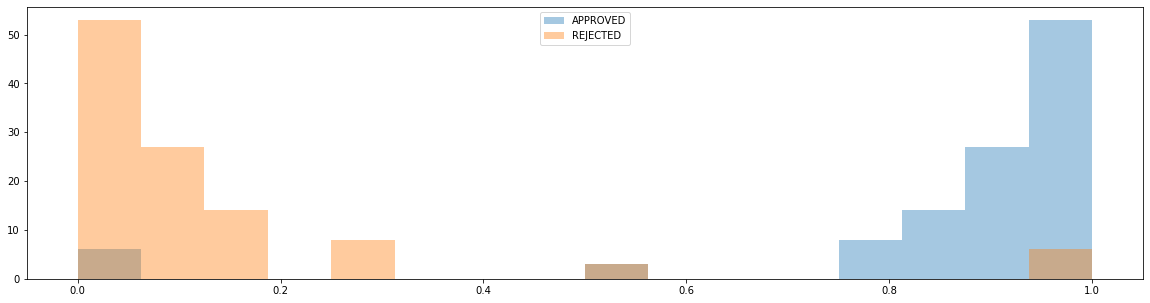

In [63]:
plt.figure(figsize=(20,5))
sns.distplot(y_pred_proba[:,1], kde=False, label='APPROVED')
sns.distplot(y_pred_proba[:,0], kde=False, label='REJECTED')
plt.legend()
plt.show()

## Cross Validation

In [64]:
clf = tree.DecisionTreeClassifier()

In [65]:
cv_results = cross_validate(clf, X, y, cv=5)

In [66]:
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_score']

In [67]:
cv_results['test_score']

array([0.92647059, 0.88059701, 0.92537313, 0.91044776, 0.92537313])